In [ ]:
%pip install osmnx pandas numpy networkx matplotlib tqdm
import os
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import sqrt
os.environ['NX_CURGAPH_AUTOCONFIG'] = 'True'


# 获得额外矩形数据

In [ ]:
bridge_location = (39.21732, -76.52815)
G_ox = ox.graph_from_bbox(bridge_location[0]+0.2, bridge_location[0]-0.2, 
                         bridge_location[1]-0.2, bridge_location[1]+0.2,
                         network_type='drive')  # 从OpenStreetMap下载矩形区域数据
G_nx = nx.DiGraph(G_ox)  # 标准NetworkX有向图
# 从OpenStreetMap下载的数据中提取节点和边的信息
print("Extra information got!")
nodes_new, edges_new = ox.graph_to_gdfs(G_ox)
nodes_new.to_csv('data/extra/nodes_drive.csv')
edges_new.to_csv('data/extra/edges_drive.csv')
nodes_new = pd.read_csv('data/extra/nodes_drive.csv')
edges_new = pd.read_csv('data/extra/edges_drive.csv')

edges_drive = pd.read_csv('data/edges_drive.csv')
nodes_drive = pd.read_csv('data/nodes_drive.csv')
edges_drive = pd.concat([edges_drive, edges_new])
nodes_drive = pd.concat([nodes_drive, nodes_new])
# 去重
edges_drive = edges_drive.drop_duplicates()
nodes_drive = nodes_drive.drop_duplicates()
# 保存
edges_drive.to_csv('data/edges_drive_merge.csv', index=False)
nodes_drive.to_csv('data/nodes_drive_merge.csv', index=False)

In [ ]:
bridge = [
    (11763173296, 10053084035),
    (11763173296, 11763173294),
    (11763173297, 11763173295),
    (11763173295, 11763173297),
    (11763173295, 49509081),
]
bridge_location = (39.21732, -76.52815)
bridge_nodes = [11763173294, 11763173295, 11763173296, 11763173297]
edges_all = pd.read_csv('data/edges_drive_merge.csv')
nodes_all = pd.read_csv('data/nodes_drive_merge.csv')
edges_all["lanes"] = pd.to_numeric(edges_all["lanes"], errors="coerce")
edges_all["maxspeed"] = edges_all["maxspeed"].apply(
    lambda x: x.replace("mph", "").strip() if isinstance(x, str) else x
)
edges_all["maxspeed"] = edges_all["maxspeed"].apply(
    lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x
)

edges_all["highway"] = edges_all["highway"].apply(
    lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x
)
edges_all["maxspeed"] = pd.to_numeric(edges_all["maxspeed"], errors="coerce")

# 按highway分组计算lanes的中位数
highway_lanes_median = edges_all.groupby('highway')['lanes'].transform('median')
edges_all["lanes"] = edges_all["lanes"].fillna(highway_lanes_median)
edges_all["maxspeed"] = edges_all["maxspeed"].fillna(55)

In [79]:
pos = dict()
for _, row in nodes_all.iterrows():
    pos[row["osmid"]] = (row["x"], row["y"])
def get_lane_capacity(row):
    # 道路类型与基准单位通行能力
    if "motorway" in row["highway"] or "motorway_link" in row["highway"] or "trunk" in row["highway"] or "trunk_link" in row["highway"]:
        base_capacity = 2200  # 高速公路单位通行能力
    elif "primary" in row["highway"] or "secondary" in row["highway"] or "primary_link" in row["highway"] or "secondary_link" in row["highway"]:
        base_capacity = 1800  # 主干道单位通行能力
    elif "residential" in row["highway"] or "tertiary" in row["highway"] or "residential_link" in row["highway"] or "tertiary_link" in row["highway"]:
        base_capacity = 1500  # 城市街道单位通行能力
    else:
        base_capacity = 1600  # 默认值

    # 根据限速调整单位通行能力
    max_speed = row["maxspeed"]
    if max_speed == 0:
        # 道路类型与基准单位通行能力
        if "motorway" in row["highway"] or "motorway_link" in row["highway"] or "trunk" in row["highway"] or "trunk_link" in row["highway"]:
            max_speed = 70  # 高速公路单位通行能力
        elif "primary" in row["highway"] or "secondary" in row["highway"] or "primary_link" in row["highway"] or "secondary_link" in row["highway"]:
            max_speed = 35  # 主干道单位通行能力
        elif "residential" in row["highway"] or "tertiary" in row["highway"] or "residential_link" in row["highway"] or "tertiary_link" in row["highway"]:
            max_speed = 25  # 城市街道单位通行能力
        else:
            max_speed = 40  # 默认值
    if isinstance(max_speed, str):
        max_speed = max_speed.split()[0]  # 只取数值部分
    max_speed = int(max_speed)

    # 假设每增加10 km/h，通行能力增加10%
    speed_factor = 1 + (max_speed - 50) / 500  # 基准速度50 km/h

    lane_capacity = base_capacity * speed_factor
    return lane_capacity


def calculate_capacity(row):
    lanes = row["lanes"]  # 车道数
    lane_capacity = get_lane_capacity(row)  # 每车道单位通行能力
    capacity = lanes * lane_capacity  # 总通行能力
    return capacity


# Initialize capacity as a dictionary of dictionaries
capacity = {}
for _, row in edges_all.iterrows():
    if row["u"] not in capacity:
        capacity[row["u"]] = {}
    capacity[row["u"]][row["v"]] = calculate_capacity(row)

In [80]:
# 将capacity转换为列表并排序
capacity_list = []
for u in capacity:
    for v in capacity[u]:
        capacity_list.append((u, v, capacity[u][v]))
        
capacity_sorted = sorted(capacity_list, key=lambda x: x[2], reverse=True)

# 获取前10条容量最大的道路
top_10_roads = capacity_sorted[:10]

# 在地图上标记这些道路
m = folium.Map(location=bridge_location, zoom_start=13)

for i, (u, v, cap) in enumerate(top_10_roads):
    # 获取起点和终点坐标
    u_coord = (nodes_all.loc[nodes_all['osmid'] == u, 'y'].values[0], 
               nodes_all.loc[nodes_all['osmid'] == u, 'x'].values[0])
    v_coord = (nodes_all.loc[nodes_all['osmid'] == v, 'y'].values[0],
               nodes_all.loc[nodes_all['osmid'] == v, 'x'].values[0])
    
    # 添加起点标记
    folium.CircleMarker(
        location=u_coord,
        radius=8,
        color='red',
        fill=True,
        popup=f'Road {i+1} Start: Capacity={cap:.0f}'
    ).add_to(m)
    
    # 添加终点标记
    folium.CircleMarker(
        location=v_coord,
        radius=8,
        color='blue',
        fill=True,
        popup=f'Road {i+1} End: Capacity={cap:.0f}'
    ).add_to(m)
    
    # 连接起点和终点
    folium.PolyLine(
        locations=[u_coord, v_coord],
        color='green',
        weight=2,
        popup=f'Road {i+1}: Capacity={cap:.0f}'
    ).add_to(m)

display(m)


In [96]:
import folium
import math

north_center = (39.240744, -76.460033)
south_center = (39.183769, -76.589530)
north_district = []
south_district = []
r_north = 6000
r_south = 3000
m = folium.Map(location=bridge_location, zoom_start=13, tiles='CartoDB positron')
folium.Circle(
    north_center, 
    radius=6000, 
    color='#4CAF50',
    weight=3,
    fill=True,
    fill_color='#4CAF50', 
    fill_opacity=0.2
).add_to(m)
folium.Circle(
    south_center, 
    radius=6000, 
    color='#FF9800',
    weight=3, 
    fill=True,
    fill_color='#FF9800',
    fill_opacity=0.2
).add_to(m)
display(m)

In [86]:
# 获取南北区域内的最大容量点
north_max_capacity = []
south_max_capacity = []

# 遍历所有边
for u, v, data in G.edges(data=True):
    cap = data['capacity']
    
    # 检查起点是否在北区
    if u in north_district:
        north_max_capacity.append((u, cap))
    
    # 检查起点是否在南区 
    if u in south_district:
        south_max_capacity.append((u, cap))

# 按容量排序并获取前5个
north_top5 = sorted(north_max_capacity, key=lambda x: x[1], reverse=True)[:5]
south_top5 = sorted(south_max_capacity, key=lambda x: x[1], reverse=True)[:5]
print(north_top5)

# 在地图上标记这些点
m = folium.Map(location=bridge_location, zoom_start=12)

# 添加北区和南区的圆形范围
folium.Circle(north_center, radius=r_north, color='blue', fill=True, fill_opacity=0.1).add_to(m)
folium.Circle(south_center, radius=r_south, color='red', fill=True, fill_opacity=0.1).add_to(m)

# 标记北区点
for node, cap in north_top5:
    coord = (nodes_all.loc[nodes_all['osmid']==node, 'y'].values[0], 
            nodes_all.loc[nodes_all['osmid']==node, 'x'].values[0])
    folium.CircleMarker(
        location=coord,
        radius=2,
        color='blue',
        fill=True,
        popup=f'北区节点: {node}<br>容量: {cap:.0f}',
        tooltip=f'容量: {cap:.0f}'
    ).add_to(m)

# 标记南区点
for node, cap in south_top5:
    coord = (nodes_all.loc[nodes_all['osmid']==node, 'y'].values[0],
            nodes_all.loc[nodes_all['osmid']==node, 'x'].values[0])
    folium.CircleMarker(
        location=coord,
        radius=2,
        color='red', 
        fill=True,
        popup=f'南区节点: {node}<br>容量: {cap:.0f}',
        tooltip=f'容量: {cap:.0f}'
    ).add_to(m)

# 添加图例
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 150px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     padding: 10px;
     ">
     &nbsp; 图例 <br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i> 北区高容量点 <br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i> 南区高容量点
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

display(m)


[(892620177, 8640.0), (37677142, 8640.0), (37677142, 8640.0), (37672234, 8640.0), (37672234, 8640.0)]


In [84]:
import random
G = nx.DiGraph()
def getdis(x, y):
    R = 6371000  # 地球半径(米)
    lat1, lon1 = x[1], x[0]
    lat2, lon2 = y[0], y[1]
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

for _, row in edges_all.iterrows():
    if row["u"] == row["v"]:
        continue
    # if getdis(pos[row["u"]], bridge_location) > rng or getdis(pos[row["v"]], bridge_location) > rng:
    #     continue
    G.add_edge(
        u_of_edge=row["u"],
        v_of_edge=row["v"],
        capacity=capacity[row["u"]][row["v"]],
        weight=row["length"],
    )
for _, row in nodes_all.iterrows():
    if (getdis((row["x"], row["y"]), north_center) < r_north):
        north_district.append(row["osmid"])
        
    if (getdis((row["x"], row["y"]), south_center) < r_south):
        south_district.append(row["osmid"])

print(len(north_district))
print(len(south_district))
# 随机选择1000个节点对
print("随机选择1000个节点对...")

G_before = G.copy()
random.seed(42)  # 设置随机种子以保证结果可重复
node_pairs = []
while len(node_pairs) < 1000:
    i = random.choice(list(north_district))
    j = random.choice(list(south_district))
    if (i, j) not in node_pairs and i in G and j in G:
        node_pairs.append((i, j))

# 存储桥梁倒塌前的所有路径长度
before_collapse = {}
total_length_before = 0
print("计算桥梁倒塌前的距离...")
for i, j in tqdm(node_pairs, desc="计算前"):
    if nx.has_path(G, i, j):
        length = nx.shortest_path_length(G, i, j, weight="weight")
        before_collapse[(i, j)] = length
        total_length_before += length

print(f"\n倒塌前的最终平均距离: {total_length_before//len(node_pairs):.2f}米")

# 存储桥梁倒塌后的所有路径长度和影响程度
after_collapse = {}
total_length_after = 0
severe_impact = []    # 严重影响 >2倍
moderate_impact = []  # 有影响 1.5-2倍
slight_impact = []    # 有一定影响 1.1-1.5倍
minimal_impact = []   # 几乎无影响 1-1.1倍
no_path = []         # 不可达

print("\n计算桥梁倒塌后的距离...")

for u, v in bridge:
    G.remove_edge(u, v)
    
G_after = G.copy()
     
for (i, j) in tqdm(before_collapse.keys(), desc="计算后"):
    if nx.has_path(G, i, j):
        length_after = nx.shortest_path_length(G, i, j, weight="weight")
        after_collapse[(i, j)] = length_after
        total_length_after += length_after
        # 计算变化比例
        ratio = length_after / before_collapse[(i, j)]

        if ratio > 2:
            severe_impact.append((i, j, ratio))
        elif ratio >= 1.5:
            moderate_impact.append((i, j, ratio))
        elif ratio >= 1.1:
            slight_impact.append((i, j, ratio))
        else:
            minimal_impact.append((i, j, ratio))
    else:
        no_path.append((i, j))

print(f"\n倒塌后的最终平均距离: {total_length_after/len(node_pairs):.2f}米")

# 打印统计结果
print("\n影响分析结果：")
print(
    f"平均距离增加比例: {(total_length_after/len(node_pairs))/(total_length_before/len(node_pairs)):.2f}倍")
print(
    f"严重影响（>2倍）的路径数量: {len(severe_impact)} ({len(severe_impact)/len(before_collapse)*100:.2f}%)")
print(
    f"有影响（1.5-2倍）的路径数量: {len(moderate_impact)} ({len(moderate_impact)/len(before_collapse)*100:.2f}%)")
print(
    f"有一定影响（1.1-1.5倍）的路径数量: {len(slight_impact)} ({len(slight_impact)/len(before_collapse)*100:.2f}%)")
print(
    f"几乎无影响（1-1.1倍）的路径数量: {len(minimal_impact)} ({len(minimal_impact)/len(before_collapse)*100:.2f}%)")
print(
    f"不可达的路径数量: {len(no_path)} ({len(no_path)/len(before_collapse)*100:.2f}%)")

# 打印一些具体例子
print("\n严重影响的路径示例（显示前5个）：")
for i, j, ratio in sorted(severe_impact, key=lambda x: x[2], reverse=True)[:5]:
    print(
        f"从 {i} 到 {j}: 增加了 {ratio:.2f} 倍 (前: {before_collapse[(i,j)]:.0f}米, 后: {after_collapse[(i,j)]:.0f}米)")

print("\n有影响的路径示例（显示前5个）：")
for i, j, ratio in sorted(moderate_impact, key=lambda x: x[2], reverse=True)[:5]:
    print(
        f"从 {i} 到 {j}: 增加了 {ratio:.2f} 倍 (前: {before_collapse[(i,j)]:.0f}米, 后: {after_collapse[(i,j)]:.0f}米)")

if no_path:
    print("\n部分不可达路径示例（显示前5个）：")
    for i, j in no_path[:5]:
        print(f"从 {i} 到 {j}: 不可达 (原距离: {before_collapse[(i,j)]:.0f}米)")

4869
2565
随机选择1000个节点对...
计算桥梁倒塌前的距离...


计算前: 100%|██████████| 1000/1000 [00:36<00:00, 27.10it/s]



倒塌前的最终平均距离: 19064.00米

计算桥梁倒塌后的距离...


计算后: 100%|██████████| 996/996 [01:00<00:00, 16.36it/s]


倒塌后的最终平均距离: 24276.38米

影响分析结果：
平均距离增加比例: 1.27倍
严重影响（>2倍）的路径数量: 7 (0.70%)
有影响（1.5-2倍）的路径数量: 151 (15.16%)
有一定影响（1.1-1.5倍）的路径数量: 599 (60.14%)
几乎无影响（1-1.1倍）的路径数量: 235 (23.59%)
不可达的路径数量: 4 (0.40%)

严重影响的路径示例（显示前5个）：
从 37283075 到 49413807: 增加了 2.37 倍 (前: 8294米, 后: 19632米)
从 683046426 到 27029943: 增加了 2.29 倍 (前: 11487米, 后: 26361米)
从 37563620 到 49510098: 增加了 2.20 倍 (前: 8757米, 后: 19230米)
从 10053084035 到 8916262057: 增加了 2.13 倍 (前: 12492米, 后: 26631米)
从 37665869 到 5468494783: 增加了 2.10 倍 (前: 10734米, 后: 22549米)

有影响的路径示例（显示前5个）：
从 37745374 到 2606299291: 增加了 1.98 倍 (前: 12040米, 后: 23856米)
从 37595810 到 2932651500: 增加了 1.98 倍 (前: 12029米, 后: 23801米)
从 37433589 到 3768315269: 增加了 1.97 倍 (前: 12125米, 后: 23940米)
从 37745374 到 2137747110: 增加了 1.97 倍 (前: 12215米, 后: 24030米)
从 37656731 到 4580382043: 增加了 1.95 倍 (前: 13347米, 后: 26019米)

部分不可达路径示例（显示前5个）：
从 11763173296 到 4580382048: 不可达 (原距离: 12070米)
从 11763173296 到 102583639: 不可达 (原距离: 15263米)
从 775383890 到 1062800588: 不可达 (原距离: 9557米)
从 775383890 到 3768315264: 不可达 (

In [93]:
# 从northtop5和southtop5各取一个节点进行分析
print("\n对南北两岸重要节点的影响分析:")
northtop5 = []
southtop5 = []
for node, cap in north_top5:
    coord = (nodes_all.loc[nodes_all['osmid'] == node, 'y'].values[0],
             nodes_all.loc[nodes_all['osmid'] == node, 'x'].values[0])
    northtop5.append(node)
for node, cap in south_top5:
    coord = (nodes_all.loc[nodes_all['osmid'] == node, 'y'].values[0],
             nodes_all.loc[nodes_all['osmid'] == node, 'x'].values[0])
    southtop5.append(node)

# 创建新的节点对
new_node_pairs = []
for n in northtop5:
    for s in southtop5:
        new_node_pairs.append((n, s))

# 初始化统计列表
new_severe_impact = []
new_moderate_impact = []
new_slight_impact = []
new_minimal_impact = []
new_no_path = []

# 计算桥梁倒塌前后的总距离
new_total_length_before = 0
new_total_length_after = 0

# 存储倒塌前后的距离
new_before_collapse = {}
new_after_collapse = {}

# 计算每对节点间的最短路径
for i, j in new_node_pairs:
    try:
        # 倒塌前的距离
        length_before = nx.shortest_path_length(G_before, i, j, weight='length')
        new_before_collapse[(i, j)] = length_before
        new_total_length_before += length_before
        
        # 倒塌后的距离
        length_after = nx.shortest_path_length(G_after, i, j, weight='length')
        new_after_collapse[(i, j)] = length_after
        new_total_length_after += length_after
        
        # 计算变化比例
        ratio = length_after / length_before
        
        if ratio > 2:
            new_severe_impact.append((i, j, ratio))
        elif ratio >= 1.5:
            new_moderate_impact.append((i, j, ratio))
        elif ratio >= 1.1:
            new_slight_impact.append((i, j, ratio))
        else:
            new_minimal_impact.append((i, j, ratio))
    except nx.NetworkXNoPath:
        new_no_path.append((i, j))

# 打印统计结果
print("\n重要节点影响分析结果：")
print(f"平均距离增加比例: {(new_total_length_after/len(new_node_pairs))/(new_total_length_before/len(new_node_pairs)):.2f}倍")
print(f"严重影响（>2倍）的路径数量: {len(new_severe_impact)} ({len(new_severe_impact)/len(new_node_pairs)*100:.2f}%)")
print(f"有影响（1.5-2倍）的路径数量: {len(new_moderate_impact)} ({len(new_moderate_impact)/len(new_node_pairs)*100:.2f}%)")
print(f"有一定影响（1.1-1.5倍）的路径数量: {len(new_slight_impact)} ({len(new_slight_impact)/len(new_node_pairs)*100:.2f}%)")
print(f"几乎无影响（1-1.1倍）的路径数量: {len(new_minimal_impact)} ({len(new_minimal_impact)/len(new_node_pairs)*100:.2f}%)")
print(f"不可达的路径数量: {len(new_no_path)} ({len(new_no_path)/len(new_node_pairs)*100:.2f}%)")

# 打印具体例子
if new_severe_impact:
    print("\n重要节点间严重影响的路径：")
    for i, j, ratio in sorted(new_severe_impact, key=lambda x: x[2], reverse=True):
        print(f"从 {i} 到 {j}: 增加了 {ratio:.2f} 倍 (前: {new_before_collapse[(i,j)]:.0f}米, 后: {new_after_collapse[(i,j)]:.0f}米)")

if new_moderate_impact:
    print("\n重要节点间有影响的路径：")
    for i, j, ratio in sorted(new_moderate_impact, key=lambda x: x[2], reverse=True):
        print(f"从 {i} 到 {j}: 增加了 {ratio:.2f} 倍 (前: {new_before_collapse[(i,j)]:.0f}米, 后: {new_after_collapse[(i,j)]:.0f}米)")

if new_no_path:
    print("\n重要节点间不可达路径：")
    for i, j in new_no_path:
        print(f"从 {i} 到 {j}: 不可达 (原距离: {new_before_collapse.get((i,j), '未知')}米)")


对南北两岸重要节点的影响分析:
25

重要节点影响分析结果：
平均距离增加比例: 1.46倍
严重影响（>2倍）的路径数量: 0 (0.00%)
有影响（1.5-2倍）的路径数量: 12 (48.00%)
有一定影响（1.1-1.5倍）的路径数量: 13 (52.00%)
几乎无影响（1-1.1倍）的路径数量: 0 (0.00%)
不可达的路径数量: 0 (0.00%)

重要节点间有影响的路径：
从 37672234 到 585251496: 增加了 1.57 倍 (前: 42米, 后: 66米)
从 37672234 到 585251496: 增加了 1.57 倍 (前: 42米, 后: 66米)
从 37672234 到 102627407: 增加了 1.56 倍 (前: 43米, 后: 67米)
从 37672234 到 102627407: 增加了 1.56 倍 (前: 43米, 后: 67米)
从 37672234 到 102627407: 增加了 1.56 倍 (前: 43米, 后: 67米)
从 37672234 到 102627407: 增加了 1.56 倍 (前: 43米, 后: 67米)
从 892620177 到 585251496: 增加了 1.55 倍 (前: 42米, 后: 65米)
从 892620177 到 102627407: 增加了 1.53 倍 (前: 43米, 后: 66米)
从 892620177 到 102627407: 增加了 1.53 倍 (前: 43米, 后: 66米)
从 37672234 到 6411991437: 增加了 1.52 倍 (前: 44米, 后: 67米)
从 37672234 到 6411991437: 增加了 1.52 倍 (前: 44米, 后: 67米)
从 892620177 到 6411991437: 增加了 1.50 倍 (前: 44米, 后: 66米)


/var/folders/hm/1s79z3cn6wlg9ngd9r911hfh0000gn/T/ipykernel_25177/962024377.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


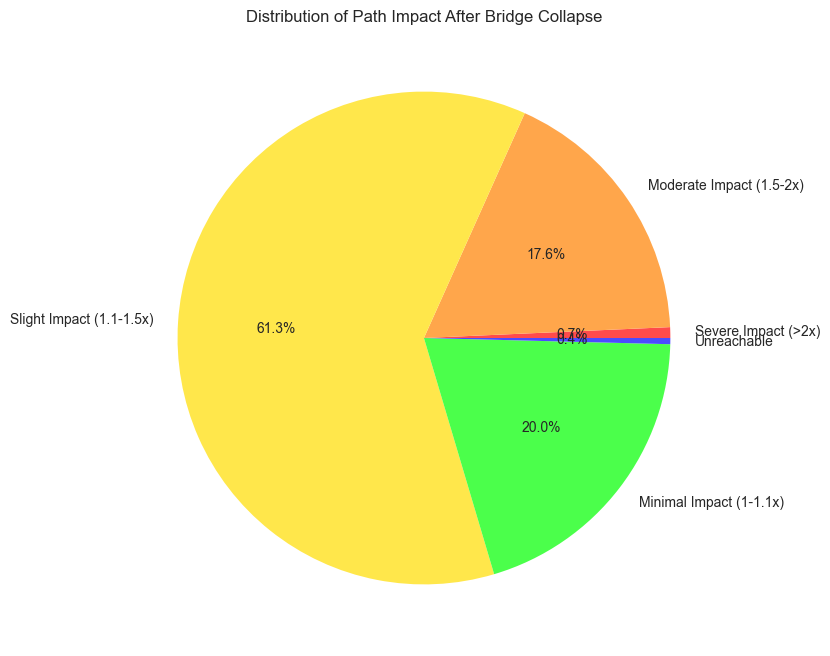

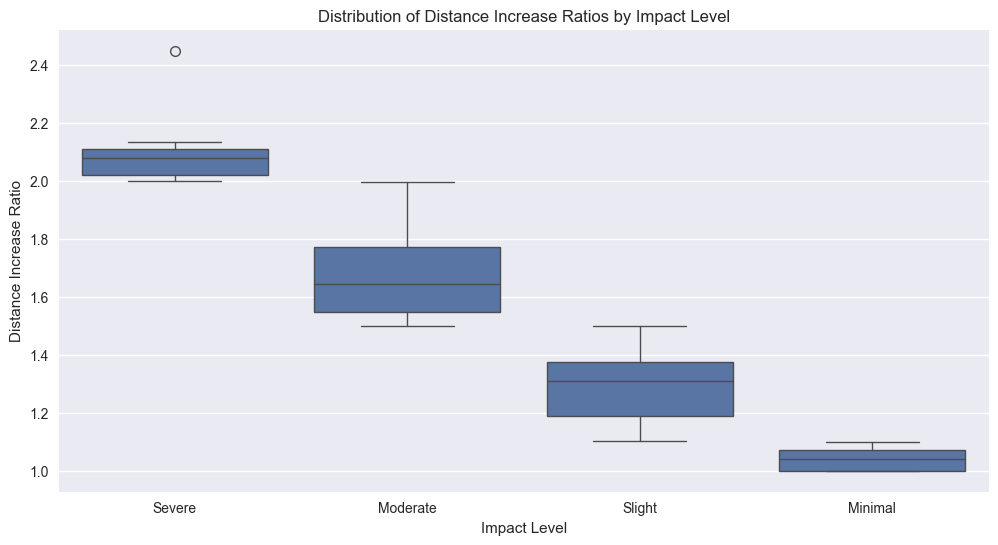

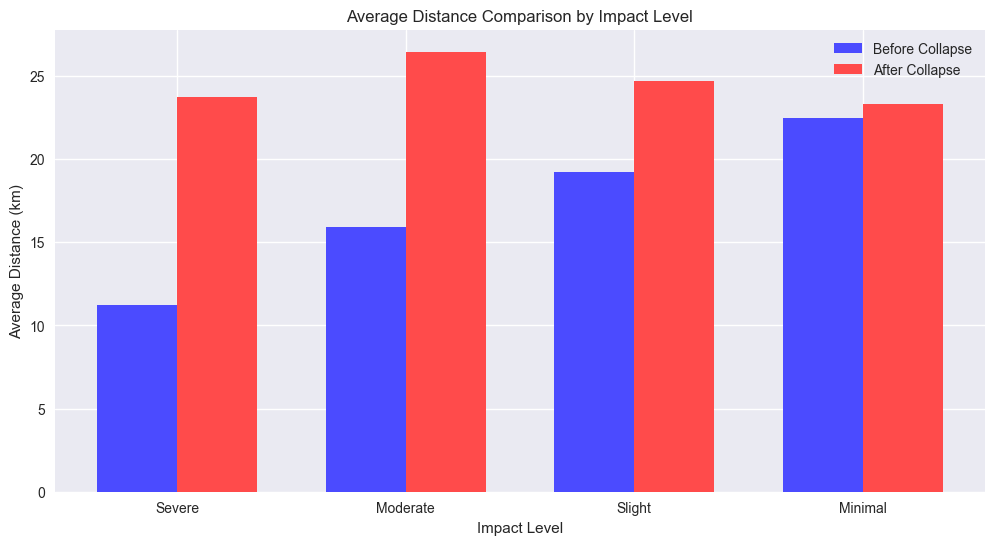

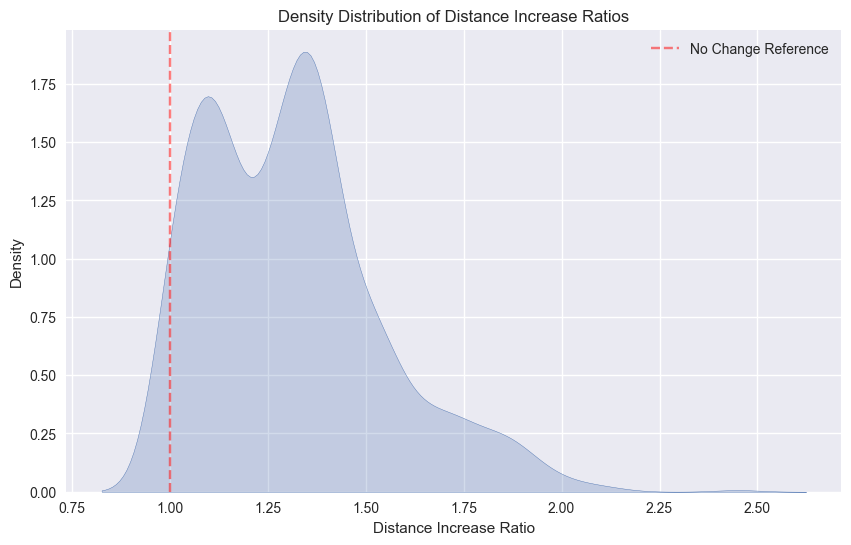

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus'] = False

# 1. Pie Chart: Impact Distribution
plt.figure(figsize=(10, 8))
impact_sizes = [
    len(severe_impact),
    len(moderate_impact),
    len(slight_impact),
    len(minimal_impact),
    len(no_path)
]
impact_labels = [
    'Severe Impact (>2x)',
    'Moderate Impact (1.5-2x)',
    'Slight Impact (1.1-1.5x)',
    'Minimal Impact (1-1.1x)',
    'Unreachable'
]
colors = ['#FF4B4B', '#FFA64B', '#FFE74B', '#4BFF4B', '#4B4BFF']
plt.pie(impact_sizes, labels=impact_labels, colors=colors, autopct='%1.1f%%')
plt.title('Distribution of Path Impact After Bridge Collapse')
plt.savefig('impact_distribution_pie.png', bbox_inches='tight', dpi=300)
plt.show()

# 2. Box Plot: Distance Ratio Distribution
plt.figure(figsize=(12, 6))
ratios = []
labels = []
for i, j, ratio in severe_impact:
    ratios.append(ratio)
    labels.append('Severe')
for i, j, ratio in moderate_impact:
    ratios.append(ratio)
    labels.append('Moderate')
for i, j, ratio in slight_impact:
    ratios.append(ratio)
    labels.append('Slight')
for i, j, ratio in minimal_impact:
    ratios.append(ratio)
    labels.append('Minimal')

sns.boxplot(x=labels, y=ratios)
plt.title('Distribution of Distance Increase Ratios by Impact Level')
plt.ylabel('Distance Increase Ratio')
plt.xlabel('Impact Level')
plt.savefig('distance_ratio_boxplot.png', bbox_inches='tight', dpi=300)
plt.show()

# 3. Bar Chart: Distance Comparison
plt.figure(figsize=(12, 6))
categories = ['Severe', 'Moderate', 'Slight', 'Minimal']
avg_before = []
avg_after = []

for impact_list in [severe_impact, moderate_impact, slight_impact, minimal_impact]:
    if impact_list:
        before_dist = [before_collapse[(i, j)] for i, j, _ in impact_list]
        after_dist = [after_collapse[(i, j)] for i, j, _ in impact_list]
        avg_before.append(np.mean(before_dist)/1000)  # Convert to kilometers
        avg_after.append(np.mean(after_dist)/1000)    # Convert to kilometers

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, avg_before, width,
        label='Before Collapse', color='#4B4BFF')
plt.bar(x + width/2, avg_after, width, label='After Collapse', color='#FF4B4B')
plt.title('Average Distance Comparison by Impact Level')
plt.xlabel('Impact Level')
plt.ylabel('Average Distance (km)')
plt.xticks(x, categories)
plt.legend()
plt.savefig('distance_comparison_bar.png', bbox_inches='tight', dpi=300)
plt.show()

# 4. Density Plot: Distance Ratio Distribution
plt.figure(figsize=(10, 6))
ratios = np.array([ratio for _, _, ratio in severe_impact +
                  moderate_impact + slight_impact + minimal_impact])
sns.kdeplot(data=ratios, fill=True)
plt.title('Density Distribution of Distance Increase Ratios')
plt.xlabel('Distance Increase Ratio')
plt.ylabel('Density')
plt.axvline(x=1, color='r', linestyle='--',
            alpha=0.5, label='No Change Reference')
plt.legend()
plt.savefig('distance_ratio_density.png', bbox_inches='tight', dpi=300)
plt.show()

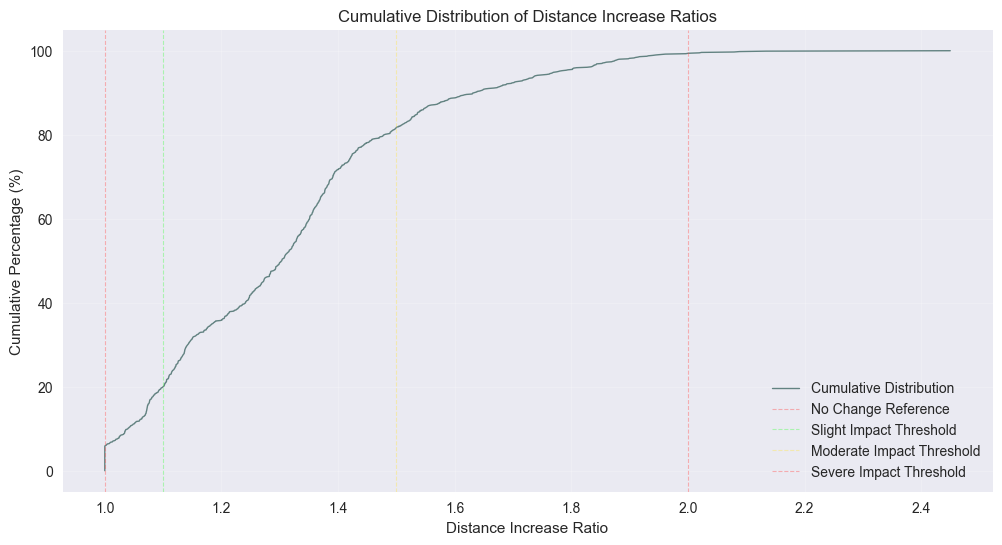

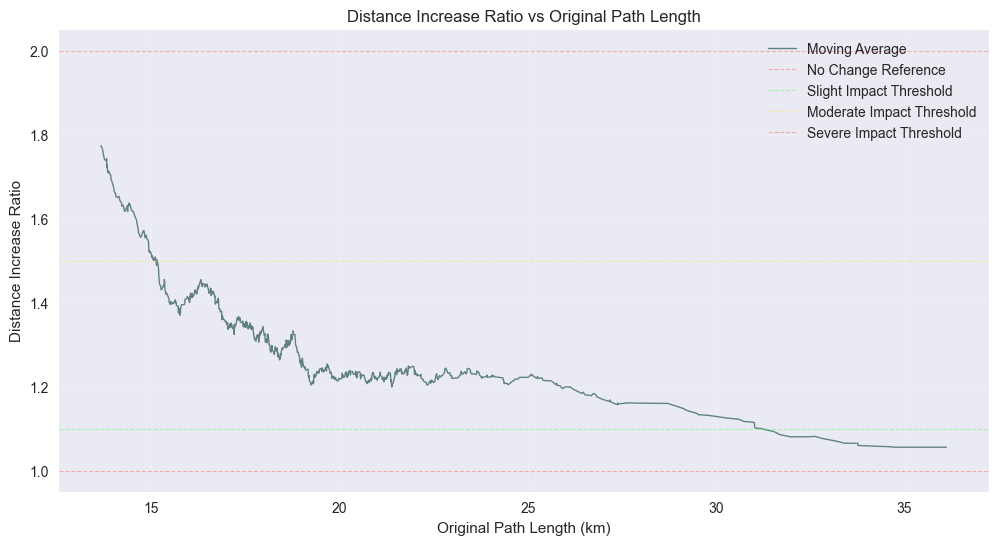

In [71]:
# 5. Line Plot - Option 1: Cumulative Distribution
plt.figure(figsize=(12, 6))

# 计算所有有效路径的比率并排序
all_ratios = sorted([ratio for _,_,ratio in severe_impact + moderate_impact + slight_impact + minimal_impact])
cumulative_percentage = np.linspace(0, 100, len(all_ratios))

plt.plot(all_ratios, cumulative_percentage, color='#628281', linewidth=1, label='Cumulative Distribution')
plt.axvline(x=1, color='#FF4B4B', linestyle='--', alpha=0.4, linewidth=0.8, label='No Change Reference')
plt.axvline(x=1.1, color='#4BFF4B', linestyle='--', alpha=0.4, linewidth=0.8, label='Slight Impact Threshold')
plt.axvline(x=1.5, color='#FFE74B', linestyle='--', alpha=0.4, linewidth=0.8, label='Moderate Impact Threshold')
plt.axvline(x=2.0, color='#FF4B4B', linestyle='--', alpha=0.4, linewidth=0.8, label='Severe Impact Threshold')

plt.title('Cumulative Distribution of Distance Increase Ratios')
plt.xlabel('Distance Increase Ratio')
plt.ylabel('Cumulative Percentage (%)')
plt.grid(True, alpha=0.2)
plt.legend(framealpha=0.5)
plt.savefig('distance_ratio_cumulative.png', bbox_inches='tight', dpi=300)
plt.show()

# 5. Line Plot - Option 2: Distance Change by Path Length
plt.figure(figsize=(12, 6))

# 收集所有路径的原始距离和变化比例
original_distances = []
ratios = []
for impact_list in [severe_impact, moderate_impact, slight_impact, minimal_impact]:
    for i, j, ratio in impact_list:
        original_distances.append(before_collapse[(i,j)]/1000)  # Convert to km
        ratios.append(ratio)

# 按原始距离排序
sorted_indices = np.argsort(original_distances)
sorted_distances = np.array(original_distances)[sorted_indices]
sorted_ratios = np.array(ratios)[sorted_indices]

# 使用移动平均来平滑线条
window_size = 50
smoothed_ratios = np.convolve(sorted_ratios, np.ones(window_size)/window_size, mode='valid')
smoothed_distances = sorted_distances[window_size-1:]

plt.plot(smoothed_distances, smoothed_ratios, color='#628281', linewidth=1, label='Moving Average')
plt.axhline(y=1, color='#FF4B4B', linestyle='--', alpha=0.4, linewidth=0.8, label='No Change Reference')
plt.axhline(y=1.1, color='#4BFF4B', linestyle='--', alpha=0.4, linewidth=0.8, label='Slight Impact Threshold')
plt.axhline(y=1.5, color='#FFE74B', linestyle='--', alpha=0.4, linewidth=0.8, label='Moderate Impact Threshold')
plt.axhline(y=2.0, color='#FF4B4B', linestyle='--', alpha=0.4, linewidth=0.8, label='Severe Impact Threshold')

plt.title('Distance Increase Ratio vs Original Path Length')
plt.xlabel('Original Path Length (km)')
plt.ylabel('Distance Increase Ratio')
plt.grid(True, alpha=0.2)
plt.legend(framealpha=0.5)
plt.savefig('distance_ratio_by_length.png', bbox_inches='tight', dpi=300)
plt.show()

<Figure size 1200x600 with 0 Axes>

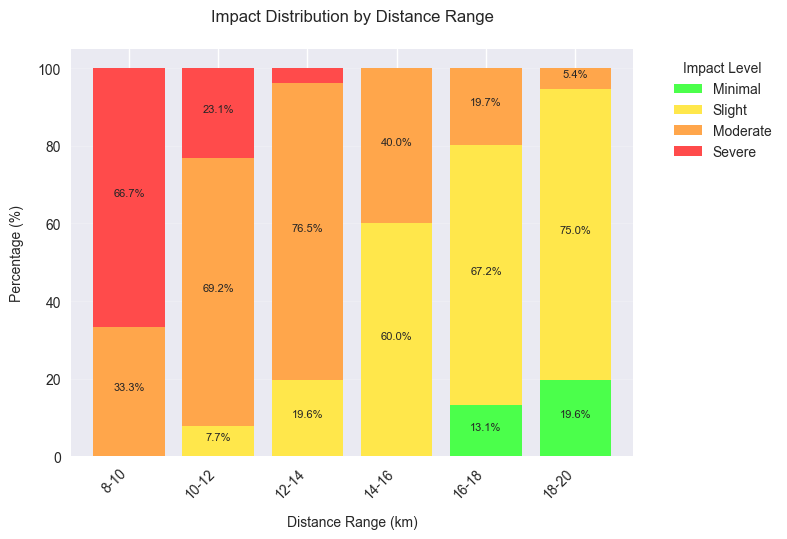

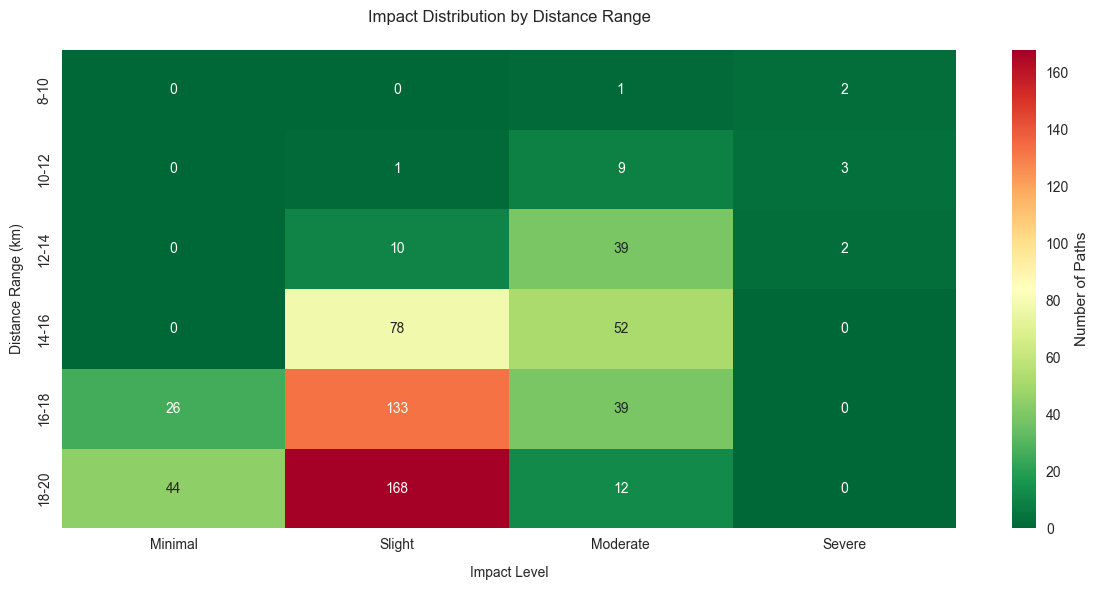


Statistical Analysis by Distance Range:

1. Path Count in Each Range:
distance_bin
0-2        0
2-4        0
4-6        0
6-8        0
8-10       3
10-12     13
12-14     51
14-16    130
16-18    198
18-20    224
Name: count, dtype: int64

2. Average Impact Ratio by Range:
distance_bin
0-2        NaN
2-4        NaN
4-6        NaN
6-8        NaN
8-10     2.009
10-12    1.846
12-14    1.693
14-16    1.451
16-18    1.362
18-20    1.253
Name: ratio, dtype: float64

3. Dominant Impact Type by Range:
distance_bin
8-10       Severe
10-12    Moderate
12-14    Moderate
14-16      Slight
16-18      Slight
18-20      Slight
dtype: object

4. Detailed Statistics by Range:


SpecificationError: nested renamer is not supported

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 创建距离区间数据
distance_data = []
for impact_list in [severe_impact, moderate_impact, slight_impact, minimal_impact]:
    for i, j, ratio in impact_list:
        distance = before_collapse[(i, j)]/1000  # 转换为km
        impact_type = 'Severe' if ratio > 2 else 'Moderate' if ratio > 1.5 else 'Slight' if ratio > 1.1 else 'Minimal'
        distance_data.append({
            'distance': distance,
            'impact': impact_type,
            'ratio': ratio
        })

df = pd.DataFrame(distance_data)

# 只保留0-20km的数据，并使用2km的区间
max_distance = 20
bin_size = 2
df = df[df['distance'] <= max_distance]
df['distance_bin'] = pd.cut(df['distance'],
                            bins=np.arange(0, max_distance +
                                           bin_size, bin_size),
                            labels=[f'{i}-{i+bin_size}' for i in range(0, max_distance, bin_size)])

# 计算每个区间内各影响程度的百分比，并按照需要的顺序重新排列
impact_order = ['Minimal', 'Slight', 'Moderate', 'Severe']  # 从下到上的顺序
impact_by_distance = pd.crosstab(
    df['distance_bin'], df['impact'], normalize='index') * 100
impact_by_distance = impact_by_distance[impact_order]  # 重新排序列

# 使用鲜明的渐变色方案
colors = ['#4BFF4B',    # 亮绿色 (Minimal)
          '#FFE74B',    # 亮黄色 (Slight)
          '#FFA64B',    # 亮橙色 (Moderate)
          '#FF4B4B']    # 亮红色 (Severe)

# 绘制堆叠柱状图
plt.figure(figsize=(12, 6))
ax = impact_by_distance.plot(kind='bar', stacked=True,
                             color=colors,
                             width=0.8)

plt.title('Impact Distribution by Distance Range', pad=20, fontsize=12)
plt.xlabel('Distance Range (km)', labelpad=10, fontsize=10)
plt.ylabel('Percentage (%)', labelpad=10, fontsize=10)
plt.legend(title='Impact Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.2, axis='y')

# 在每个柱子上添加百分比标签（只显示大于5%的值）
for c in ax.containers:
    labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center',
                 padding=3, rotation=0,
                 fontsize=8)

plt.tight_layout()
plt.savefig('impact_by_distance_range.png', bbox_inches='tight', dpi=300)
plt.show()

# 创建热力图，使用相同的顺序
plt.figure(figsize=(12, 6))
impact_counts = pd.crosstab(df['distance_bin'], df['impact'])[impact_order]
sns.heatmap(impact_counts, cmap='RdYlGn_r', annot=True, fmt='d',
            cbar_kws={'label': 'Number of Paths'})
plt.title('Impact Distribution by Distance Range', pad=20, fontsize=12)
plt.xlabel('Impact Level', labelpad=10, fontsize=10)
plt.ylabel('Distance Range (km)', labelpad=10, fontsize=10)
plt.tight_layout()
plt.savefig('impact_heatmap_by_distance.png', bbox_inches='tight', dpi=300)
plt.show()

# 打印统计信息
print("\nStatistical Analysis by Distance Range:")
print("\n1. Path Count in Each Range:")
path_counts = df['distance_bin'].value_counts().sort_index()
print(path_counts)

print("\n2. Average Impact Ratio by Range:")
avg_ratio = df.groupby('distance_bin')['ratio'].mean().sort_index()
print(avg_ratio.round(3))

print("\n3. Dominant Impact Type by Range:")
dominant_impact = impact_by_distance.idxmax(axis=1)
print(dominant_impact)

print("\n4. Detailed Statistics by Range:")
stats = df.groupby('distance_bin')['ratio'].agg({
    'Mean Ratio': 'mean',
    'Std Dev': 'std',
    'Path Count': 'count'
}).round(3)
print(stats)

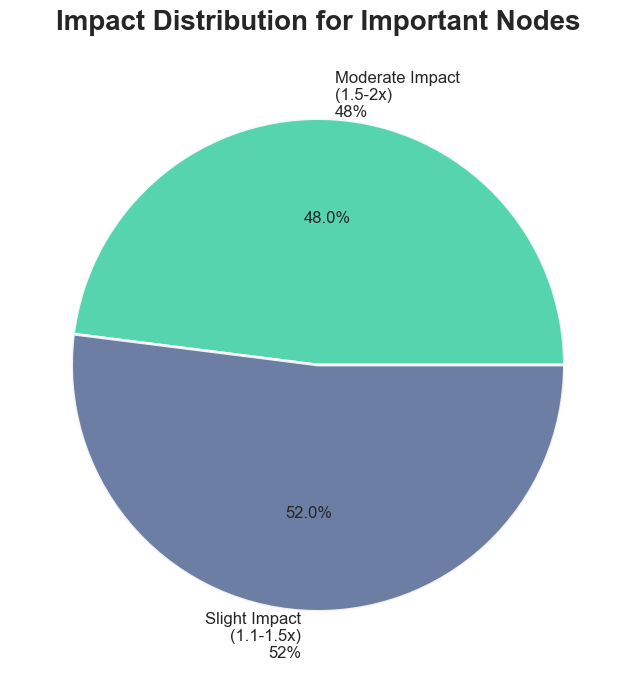

<Figure size 1400x600 with 0 Axes>

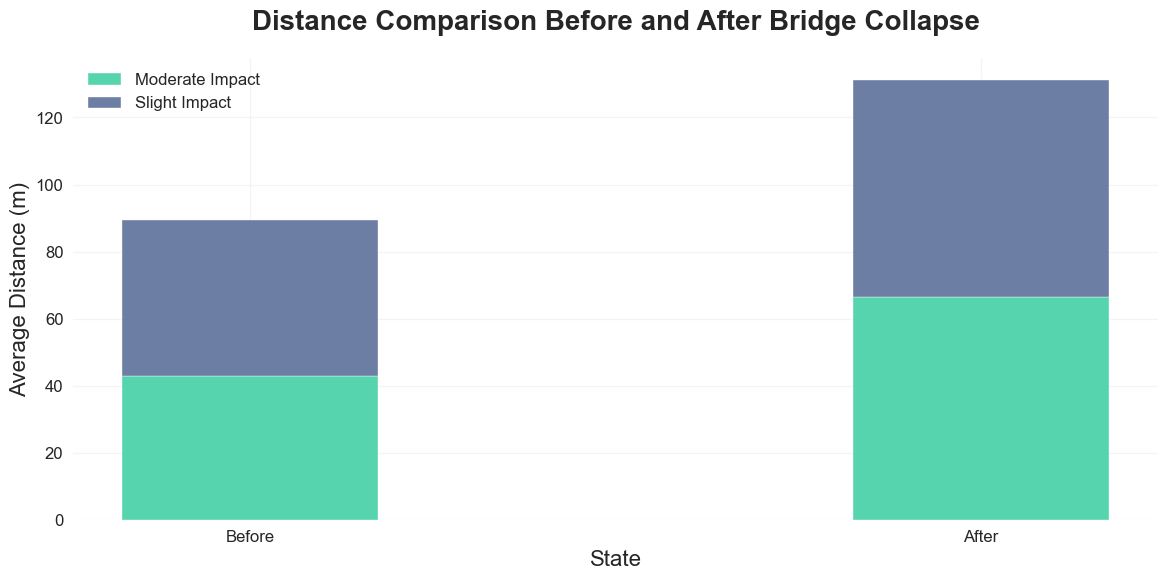

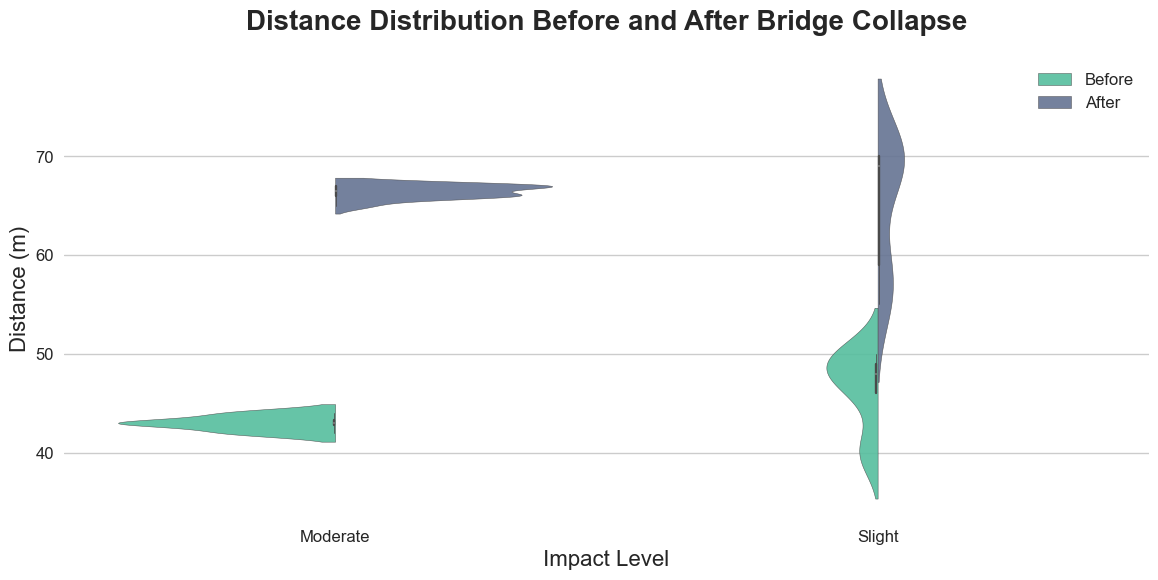

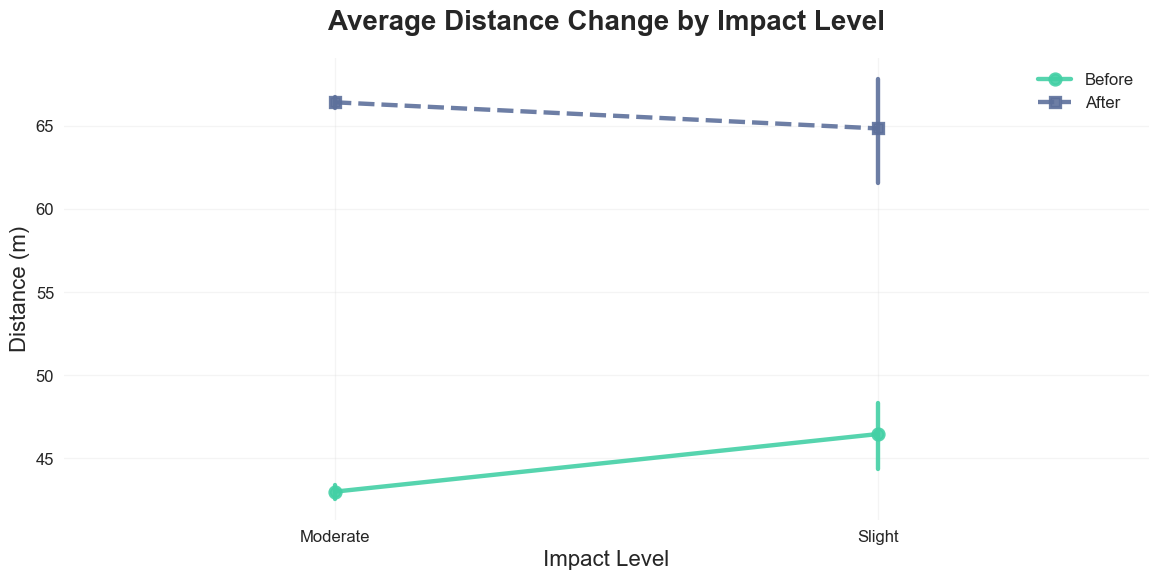

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Set style and font
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style("whitegrid")
plt.rcParams['axes.unicode_minus'] = False

# 定义蓝色系配色方案
blue_palette = ['#43d0a5', '#AEC7E8', '#5d709b', '#98DF8A']

# 1. 方案一：现代化饼图
plt.figure(figsize=(12, 8))
impact_sizes = [0, 12, 13, 0, 0]
impact_labels = [
    'Severe Impact (>2x)\n0%',
    'Moderate Impact (1.5-2x)\n48%',
    'Slight Impact (1.1-1.5x)\n52%',
    'Minimal Impact (1-1.1x)\n0%',
    'Unreachable\n0%'
]

# 只显示有数据的部分
non_zero_sizes = [12, 13]
non_zero_labels = [
    'Moderate Impact\n(1.5-2x)\n48%',
    'Slight Impact\n(1.1-1.5x)\n52%'
]

plt.pie(non_zero_sizes, labels=non_zero_labels,
        colors=[blue_palette[0], blue_palette[2]],
        autopct='%1.1f%%',
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'alpha': 0.9})
plt.title('Impact Distribution for Important Nodes',
          fontsize=20, pad=20, fontweight='bold')
plt.show()

# 2. 方案二：堆叠条形图
plt.figure(figsize=(14, 6))
categories = ['Before', 'After']
moderate_data = [np.mean([new_before_collapse[(i, j)] for i, j, _ in new_moderate_impact]),
                 np.mean([new_after_collapse[(i, j)] for i, j, _ in new_moderate_impact])]
slight_data = [np.mean([new_before_collapse[(i, j)] for i, j, _ in new_slight_impact]),
               np.mean([new_after_collapse[(i, j)] for i, j, _ in new_slight_impact])]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bottom = np.zeros(2)

p1 = ax.bar(x, moderate_data, width, label='Moderate Impact',
            color=blue_palette[0], alpha=0.9)
p2 = ax.bar(x, slight_data, width, bottom=moderate_data,
            label='Slight Impact', color=blue_palette[2], alpha=0.9)

plt.title('Distance Comparison Before and After Bridge Collapse',
          fontsize=20, pad=20, fontweight='bold')
plt.xlabel('State', fontsize=16)
plt.ylabel('Average Distance (m)', fontsize=16)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.2)
plt.show()

# 3. 方案三：分组小提琴图
plt.figure(figsize=(14, 6))
data = []
for i, j, ratio in new_moderate_impact:
    data.append({
        'Category': 'Moderate',
        'State': 'Before',
        'Distance': new_before_collapse[(i, j)]
    })
    data.append({
        'Category': 'Moderate',
        'State': 'After',
        'Distance': new_after_collapse[(i, j)]
    })

for i, j, ratio in new_slight_impact:
    data.append({
        'Category': 'Slight',
        'State': 'Before',
        'Distance': new_before_collapse[(i, j)]
    })
    data.append({
        'Category': 'Slight',
        'State': 'After',
        'Distance': new_after_collapse[(i, j)]
    })

df = pd.DataFrame(data)
sns.violinplot(data=df, x='Category', y='Distance',
               hue='State', split=True,
               palette=[blue_palette[0], blue_palette[2]],
               alpha=0.9)

plt.title('Distance Distribution Before and After Bridge Collapse',
          fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Impact Level', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='', fontsize=12)
plt.show()

# 4. 方案四：点图
plt.figure(figsize=(14, 6))
sns.pointplot(data=df, x='Category', y='Distance',
              hue='State', palette=[blue_palette[0], blue_palette[2]],
              markers=['o', 's'], linestyles=['-', '--'],
              alpha=0.9)

plt.title('Average Distance Change by Impact Level',
          fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Impact Level', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='', fontsize=12)
plt.grid(True, alpha=0.2)
plt.show()